In [10]:
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
import scipy
import numpy as np
from numpy.linalg import norm
from math import sqrt
import pandas as pd
import json
import re
import os

In [2]:
punc = re.compile(r"[\n,!\?\’'\+:\"\.\$&@#/\(\)\[\]\|\{\}]")
nonwords = re.compile('^[^a-zA-Z0-9]+$')
links = re.compile(r"https")

In [3]:
def clean_text(df, col_to_clean: str): 
    df[col_to_clean] = df[col_to_clean].str.lower().replace('\n','',regex=True).str.replace('’',"'",regex=True).str.replace(punc,'',regex=True).str.strip()
    df = df[~df[col_to_clean].str.contains(links)]
    df = df[~df[col_to_clean].str.contains(nonwords)]
    df = df[df[col_to_clean]!='']
    return df

def tokinize(df, col_to_tokenize: str):
    df['tokenized'] = df[col_to_tokenize].str.split(' ')
    return df

def get_freqs(df, col_tok='tokenized'):
    df = df.explode(col_tok)
    freqs = df[col_tok].value_counts().to_dict()
    STOPWORDS.update({punc.sub('',x) for x in STOPWORDS})
    new_freqs = {word:freq for (word,freq) in freqs.items() if word not in STOPWORDS}
    return new_freqs

In [4]:
def get_post_df(json_filename):
    df = pd.read_json(json_filename, lines=True)
    # changing the type col
    df = df.rename({"_type": "type"}, axis="columns")
    df = df.replace(to_replace="snscrape.modules.reddit.Submission", value="post")
    df = df.replace(to_replace="snscrape.modules.reddit.Comment", value="comment")
    # change to posts only
    df_posts = df[df["type"] == "post"]
    df_posts = df_posts.dropna(subset=["selftext"])
    df_posts = df_posts.drop(["body"], axis=1)
    df_posts = df_posts.drop(["type", "parentId", "subreddit", "link"], axis=1)
    df_posts = df_posts.reset_index()

    return df, df_posts

def apply_text_len(df, col_text='selftext', minimum_length=500, visualise_lengths=False):
    df['text_len'] = df[col_text].apply(len)
    if(visualise_lengths):
        plt2 = df['text_len'].plot(kind='kde',
            title="Distribution of Comment Length",
            xlabel='Comment Length',
            xlim=0)
    df = df[df["text_len"] >= minimum_length]

    df = clean_text(df, col_text)
    return df

def draw_wordcloud(freqs):
    wordcloud = WordCloud()
    wordcloud.generate_from_frequencies(frequencies=freqs)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [5]:
_, doomer_posts = get_post_df("Data/r_doomer_scraped.json")
_, lonely1_posts = get_post_df("Data/r_lonely_scraped.json")
_, lonely2_posts = get_post_df("Data/r_loneliness_scraped.json")
_, depr_posts = get_post_df("Data/r_depression_scraped.json")

In [ ]:
doomer_posts = apply_text_len(doomer_posts)
lonely1_posts = apply_text_len(lonely1_posts)
lonely2_posts = apply_text_len(lonely2_posts)
depr_posts = apply_text_len(depr_posts)

In [24]:
print(len(doomer_posts))
print(len(lonely1_posts))
print(len(lonely2_posts))
print(len(depr_posts))

2921
4860
2754
8811


In [16]:
print(f"Average length of doomer: {doomer_posts['text_len'].mean()}")
print(f"Average length of lonely1: {lonely1_posts['text_len'].mean()}")
print(f"Average length of lonely2: {lonely2_posts['text_len'].mean()}")
print(f"Average length of depr: {depr_posts['text_len'].mean()}")

Average length of doomer: 1275.1535145888595
Average length of lonely1: 1228.0242533573862
Average length of lonely2: 1489.4160427807487
Average length of depr: 1336.8282794624015


In [20]:
print("Doomer")
print(f"Earliest post: {doomer_posts['created'].min()}")
print(f"Oldest post: {doomer_posts['created'].max()}")

print("Lonely1")
print(f"Earliest post: {lonely1_posts['created'].min()}")
print(f"Oldest post: {lonely1_posts['created'].max()}")

print("Lonely2")
print(f"Earliest post: {lonely2_posts['created'].min()}")
print(f"Oldest post: {lonely2_posts['created'].max()}")

print("Depr")
print(f"Earliest post: {depr_posts['created'].min()}")
print(f"Oldest post: {depr_posts['created'].max()}")

Doomer
Earliest post: 2019-04-22T10:51:08+00:00
Oldest post: 2022-11-15T16:58:27+00:00
Lonely1
Earliest post: 2022-09-13T03:50:53+00:00
Oldest post: 2022-11-17T00:56:25+00:00
Lonely2
Earliest post: 2011-11-09T07:06:30+00:00
Oldest post: 2022-11-15T03:53:57+00:00
Depr
Earliest post: 2022-02-28T23:44:13+00:00
Oldest post: 2022-11-15T16:33:02+00:00


In [7]:
doomer_users = doomer_posts['author'].unique()
lonely1_users = lonely1_posts['author'].unique()
lonely2_users = lonely2_posts['author'].unique()
depr_users = depr_posts['author'].unique()

In [8]:
print(len(doomer_users))
print(len(lonely1_users))
print(len(lonely2_users))
print(len(depr_users))

1811
3851
2290
8332


In [9]:
doomer_lonely1_users = np.intersect1d(doomer_users, lonely1_users) 
doomer_lonely2_users = np.intersect1d(doomer_users, lonely2_users) 
doomer_depr_users = np.intersect1d(doomer_users, depr_users)

lonely1_lonely2_users = np.intersect1d(lonely1_users, lonely2_users) 
lonely1_depr_users = np.intersect1d(lonely1_users, depr_users) 
lonely2_depr_users = np.intersect1d(lonely2_users, depr_users) 

common_users1 = np.intersect1d(doomer_lonely1_users, doomer_depr_users)
common_users2 = np.intersect1d(doomer_lonely2_users, doomer_depr_users)
common_users = np.intersect1d(common_users1, common_users2)

In [30]:
print(len(doomer_lonely1_users))
print(len(doomer_lonely2_users))
print(len(doomer_depr_users))

print(len(lonely1_lonely2_users))
print(len(lonely1_depr_users))
print(len(lonely2_depr_users))

print(len(common_users1))
print(len(common_users2))
print(len(common_users))

13
6
14
31
161
25
2
1
0


In [10]:
doomer_posts = tokinize(doomer_posts, 'selftext')
lonely1_posts = tokinize(lonely1_posts, 'selftext')
lonely2_posts = tokinize(lonely2_posts, 'selftext')
depr_posts = tokinize(depr_posts, 'selftext')

In [11]:
doomer_freqs = get_freqs(doomer_posts)

In [12]:
lonely1_freqs = get_freqs(lonely1_posts)
lonely2_freqs = get_freqs(lonely2_posts)

In [13]:
depr_freqs = get_freqs(depr_posts)

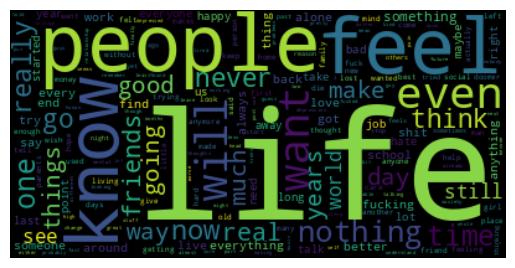

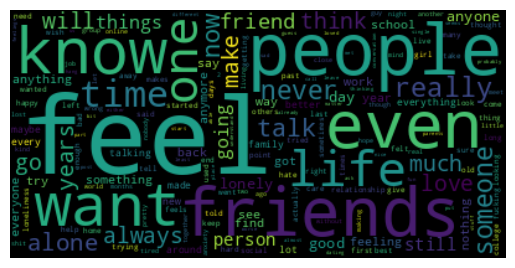

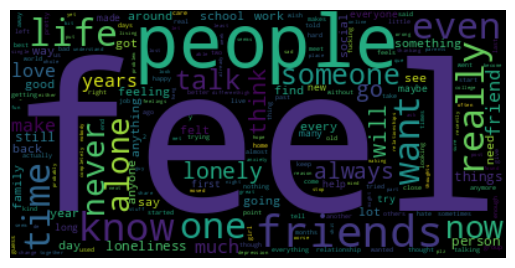

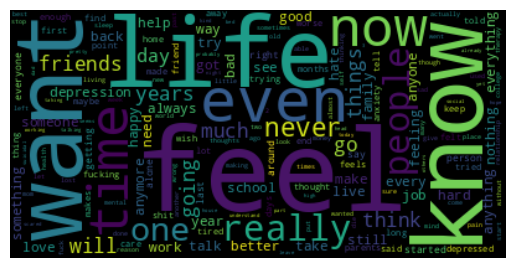

In [14]:
draw_wordcloud(doomer_freqs)
draw_wordcloud(lonely1_freqs)
draw_wordcloud(lonely2_freqs)
draw_wordcloud(depr_freqs)

In [38]:
# Save a sample to be read
# num_samples = 50
# doomer_posts.sample(n = num_samples)['selftext'].to_csv('Data/sample50_doomer.txt', sep=' ')
# lonely1_posts.sample(n = num_samples)['selftext'].to_csv('Data/sample50_lonely.txt', sep=' ')
# lonely2_posts.sample(n = num_samples)['selftext'].to_csv('Data/sample50_loneliness.txt', sep=' ')
# depr_posts.sample(n = num_samples)['selftext'].to_csv('Data/sample50_depr.txt', sep=' ')

In [25]:
doomer_corpus = doomer_posts['selftext'].str.cat(sep=" ")
lonely1_corpus = lonely1_posts['selftext'].str.cat(sep=" ")
lonely2_corpus = lonely2_posts['selftext'].str.cat(sep=" ")
depr_corpus = depr_posts['selftext'].str.cat(sep=" ")

In [1]:
themes_keywords = {
   "nihilism": ["nihil", "dark", "hopeless", "meaning", "nothing", "empty", "death", "life", "nonesense", "bleak", "reason", "pessimis", "worth"],
   "doom": ["doom", "collapse", "brutal", "survive", "consciousness", "conscience", "extinction", "clown", "climate", "ecology", "destitute"],
   "alone": ["lone", "friend", "isolated", "island", "people", "presence", "nobody", "social", "bore", "boring"],
    "medical": ["medical", "mental", "health", "issue", "diagnos", "medication", "pills", "anxiety", "psycholog", "help", "therap", "disorder", "episode", "gender", "dysphoria", "surgery", "mg", "lexapro", "doctor", "neurology"],
    "relationship": ["gf", "sex", "coom", "wank", "porn", "girl", "slut", "hore", "kiss", "edging", "virgin", "love", "masturbat", "simp", "woman", "women", "relationship", "hug", "dating", "date", "intimacy", "girlfriend", "fiance", "husband", "wife", "breakup", "marriage", "divorce", "responsibil", "understanding", "parent", "cheated"],
   "childhood": ["child", "abuse", "neglect", "mom", "parents", "dad", "mother", "father", "mum", "school", "course", "college", "university", "grade", "teacher", "professor", "youth", "young", "recess", "class"],
   "job": ["job", "work", "occupation", "career "],
   "mental health": ["mental", "depress", "diagnos", "anxiety", "anxious", "harm", "smile", "happy", "happi", "toxic", "emotion", "emotion", "energy", "sad", "pain", "ache", "happy", "happiness", "motivat", "unlove", "uncared"],
   "drugs": ["drug" "cig", "drunk", "drink", "smoke", "weed", "alcohol", "booze", "crack", "coke", "cocaine", "hemp", "marijuana", "cannabis", "intox"],
    "social issues": ["social", "shy", "talk", "support", "insecure", "rejection", "awkward", "fit", "society", "conversation", "abandon", "extroverted", "introverted", "unattractive", "ugly"],
    "responsibilities": ["responsibl", "death", "family", "pass", "job", "miscarriage", "victim"],
    # "emotional emptiness": ["emotion", "energy", "sad", "pain", "ache", "happy", "happiness", "motivat", "unloved", "unloveable", "uncared"],
}

In [6]:
themes = list(themes_keywords.keys())
keywords = [themes_keywords[themes] for themes in themes_keywords]
themes_keywords_df = pd.DataFrame({
    "themes": themes,
    "keywords": keywords
})

In [12]:
themes_keywords_latex = themes_keywords_df.to_latex(index=False, float_format="%.2f")

In [13]:
with open("Report/Sections/table_keywords1.tex", "w") as f:
    f.write(themes_keywords_latex)

In [214]:
frequencies_dict = {
    "themes": [],
    "re": [],
    "doomer_matches": [],
    "lonely1_matches": [],
    "lonely2_matches": [],
    "depr_matches": []
}

for theme in themes_keywords:
    theme_re = re.compile('|'.join(themes_keywords[theme]))
    matches_doomer = re.findall(theme_re, doomer_corpus)
    matches_lonely1 = re.findall(theme_re, lonely1_corpus)
    matches_lonely2 = re.findall(theme_re, lonely2_corpus)
    matches_depr = re.findall(theme_re, depr_corpus)

    frequencies_dict["themes"].append(theme)
    frequencies_dict["re"].append(theme_re)
    frequencies_dict["doomer_matches"].append(len(matches_doomer))
    frequencies_dict["lonely1_matches"].append(len(matches_lonely1))
    frequencies_dict["lonely2_matches"].append(len(matches_lonely2))
    frequencies_dict["depr_matches"].append(len(matches_depr))

frequencies_df = pd.DataFrame(frequencies_dict)

In [215]:
num_doomer_matches = frequencies_df["doomer_matches"].sum()
num_lonely1_matches = frequencies_df["lonely1_matches"].sum()
num_lonely2_matches = frequencies_df["lonely2_matches"].sum()
num_depr_matches = frequencies_df["depr_matches"].sum()

In [216]:
frequencies_df["doomer_freqs_tot"] = frequencies_df["doomer_matches"].div(len_doomer_corpus).mul(100)
frequencies_df["lonely1_freqs_tot"] = frequencies_df["lonely1_matches"].div(len_lonely1_corpus).mul(100)
frequencies_df["lonely2_freqs_tot"] = frequencies_df["lonely2_matches"].div(len_lonely2_corpus).mul(100)
frequencies_df["depr_freqs_tot"] = frequencies_df["depr_matches"].div(len_depr_corpus).mul(100)

frequencies_df["doomer_freqs_whole"] = frequencies_df["doomer_matches"].div(num_doomer_matches).mul(100)
frequencies_df["lonely1_freqs_whole"] = frequencies_df["lonely1_matches"].div(num_lonely1_matches).mul(100)
frequencies_df["lonely2_freqs_whole"] = frequencies_df["lonely2_matches"].div(num_lonely2_matches).mul(100)
frequencies_df["depr_freqs_whole"] = frequencies_df["depr_matches"].div(num_depr_matches).mul(100)

In [217]:
frequencies_df[["themes", "doomer_freqs_whole", "lonely1_freqs_whole", "lonely2_freqs_whole", "depr_freqs_whole"]]

,themes,doomer_freqs_whole,lonely1_freqs_whole,lonely2_freqs_whole,depr_freqs_whole
0,nihilism,18.901876,9.903743,9.592189,13.067856
1,doom,2.725041,0.219446,0.133621,0.296172
2,alone,17.478549,31.127653,33.604732,15.027605
3,medical,5.965813,5.930027,5.740348,12.393718
4,relationship,12.902281,15.199122,14.019491,10.657581
5,childhood,10.758282,8.898781,9.399776,12.125909
6,job,5.679796,4.421336,4.261612,6.542173
7,mental health,11.249240,8.927458,8.683568,16.877857
8,drugs,2.247596,0.756839,0.812414,1.266482
9,social issues,7.103124,11.145607,10.304834,6.199827


In [218]:
comp_doomer = list(frequencies_df["doomer_freqs_whole"])
comp_lonely1 = list(frequencies_df["lonely1_freqs_whole"])
comp_lonely2 = list(frequencies_df["lonely2_freqs_whole"])
comp_depr = list(frequencies_df["depr_freqs_whole"])

In [219]:
def get_distance(vec1, vec2, emphasize_first=4, emphasize_by=2):
    sum = 0
    for i in range(len(vec1)):
        if(i < emphasize_first):
            sum += ((vec1[i] - vec2[i]) ** 2) ** emphasize_by
        else:
            sum += (vec1[i] - vec2[i]) ** 2
    return sqrt(sum)

def add_list_vectors(list_vectors):
    added_vector = [0 for x in list_vectors[0]]
    for vector in list_vectors:
        for i in range(len(vector)):
            added_vector[i] += vector[i]
    return added_vector

def scale_vector(vector, scalar):
    for i in range(len(vector)):
        vector[i] *= scalar
    return vector

def ave_list_vectors(list_vectors):
    return scale_vector(add_list_vectors(list_vectors), (1 / len(list_vectors)))

In [220]:
def get_num_correct_pred(texts, label_num, re_series, num_categories=4):

    # identify the correct and incorrect labels for binary classification
    if(label_num == 1 or label_num == 2):
        comp_correct = ave_list_vectors([comp_lonely1, comp_lonely2])
        comp_incorrect = ave_list_vectors([comp_doomer, comp_depr])
    elif(label_num == 0):
        comp_correct = comp_doomer
        comp_incorrect = ave_list_vectors([comp_lonely1, comp_lonely2, comp_depr])
    elif(label_num == 3):
        comp_correct = comp_depr
        comp_incorrect = ave_list_vectors([comp_lonely1, comp_lonely2, comp_doomer])

    # doomer, lonely1, lonely2, depr, correct, incorrect, no_match
    predictions = [0 for _ in range(num_categories + 1 + 2)]
    lonely1_pred, lonely2_pred = 0, 0

    min_num_matches = 1
    for text in texts:
        comp_vector = []
        for theme_re in re_series:
            num_matches = len(re.findall(theme_re, text))
            comp_vector.append(num_matches)
        
        # let's not forget to normalise it as a whole of 100%
        num_matches = sum(comp_vector)
        if(num_matches >= min_num_matches):
            for i in range(len(comp_vector)):
                comp_vector[i] = (comp_vector[i] / num_matches) * 100

            dists = [
                get_distance(comp_vector, comp_doomer),
                get_distance(comp_vector, comp_lonely1),
                get_distance(comp_vector, comp_lonely2),
                get_distance(comp_vector, comp_depr)]

            shortest_dist_index = dists.index(min(dists))
            predictions[shortest_dist_index] += 1

            if(get_distance(comp_vector, comp_correct) < get_distance(comp_vector, comp_incorrect)):
                # correct binary
                predictions[-3] += 1
            else:
                # incorrect binary
                predictions[-2] += 1

            if(label_num == 1 or label_num == 2):
                if(get_distance(comp_vector, comp_lonely1) < get_distance(comp_vector, comp_lonely2)):
                    lonely1_pred += 1
                else:
                    lonely2_pred += 1
        else:
            # no match
            predictions[-1] += 1

    for pred in predictions:
        print(pred, ' ', end='')

    accuracy = predictions[-3] / (predictions[-3] + predictions[-2])
    print(accuracy, ' ', end='')

    if(label_num == 1 or label_num == 2):
        print(lonely1_pred, ' ', end='')
        print(lonely2_pred, ' ', end='')
        if(label_num == 1):
            print(lonely1_pred / (lonely1_pred + lonely2_pred), ' ', end='')
        else:
            print(lonely2_pred / (lonely1_pred + lonely2_pred), ' ', end='')

    print('')

In [221]:
min_length = 0
print("doomer", "lonely1", "lonely2", "depr", "correct", "incorrect", "no_match", "binary accuracy", "lonely1", "lonely2")
get_num_correct_pred(doomer_posts[doomer_posts["text_len"] >= min_length]["selftext"], 0, frequencies_df["re"])
get_num_correct_pred(lonely1_posts[lonely1_posts["text_len"] >= min_length]["selftext"], 1, frequencies_df["re"])
get_num_correct_pred(lonely2_posts[lonely2_posts["text_len"] >= min_length]["selftext"], 2, frequencies_df["re"])
get_num_correct_pred(depr_posts[depr_posts["text_len"] >= min_length]["selftext"], 3, frequencies_df["re"])

doomer lonely1 lonely2 depr correct incorrect no_match binary accuracy lonely1 lonely2
1326  310  466  895  1895  1102  19  0.6322989656322989  
830  848  2287  1012  3190  1787  12  0.6409483624673498  2690  2287  0.5404862366887684  
377  527  1487  411  2032  770  3  0.7251962883654532  1315  1487  0.5306923625981442  
2375  822  1057  4734  6452  2536  15  0.7178460169114375  


In [223]:
frequencies_latex = frequencies_df[["themes", "doomer_freqs_whole", "lonely1_freqs_whole", "lonely2_freqs_whole", "depr_freqs_whole"]].to_latex(index=False, float_format="%.2f")
print(frequencies_latex)

\begin{tabular}{lrrrr}
\toprule
                    themes &  doomer\_freqs\_whole &  lonely1\_freqs\_whole &  lonely2\_freqs\_whole &  depr\_freqs\_whole \\
\midrule
                  nihilism &               18.90 &                 9.90 &                 9.59 &             13.07 \\
                      doom &                2.73 &                 0.22 &                 0.13 &              0.30 \\
                     alone &               17.48 &                31.13 &                33.60 &             15.03 \\
                   medical &                5.97 &                 5.93 &                 5.74 &             12.39 \\
              relationship &               12.90 &                15.20 &                14.02 &             10.66 \\
                 childhood &               10.76 &                 8.90 &                 9.40 &             12.13 \\
                       job &                5.68 &                 4.42 &                 4.26 &              6.54 \\
       

/tmp/ipykernel_3580/3115676395.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  frequencies_latex = frequencies_df[["themes", "doomer_freqs_whole", "lonely1_freqs_whole", "lonely2_freqs_whole", "depr_freqs_whole"]].to_latex(index=False, float_format="%.2f")
